<h1>Data Visualization - Prod/Part Cable</h1>

This books goal is to show the ratio of cables used in the cableprobes. 

In [1]:
import json
import pandas as pd
import helpers.pipe_helpers as php
import helpers.api_helpers as ahp
import numpy as np

First I try to get every product in a specific Classification-Node (CableProbes).

In [ ]:
cable_probes = pd.DataFrame()
pointer = 0

while True:
    data = ahp.read_from_windchill_per_node("TSGCableProbes",pointer)
    json_data = json.loads(data)
    json_data_value = pd.DataFrame(json_data['value'])   
    cable_probes = pd.concat([cable_probes, json_data_value], ignore_index=True)
    
    if '@odata.nextLink' not in json_data:
        break
    
    pointer = json_data['@odata.nextLink'].split('=')[1]

In the next step I am search for unique Names. Thats used to get the part-data from windchill for every unique cableprobe.

In [ ]:
cable_probes.to_parquet('../../cache/cable_probes_from_db.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ID                                1228 non-null   object
 1   Name                              1228 non-null   object
 2   ClfBindingAttributeAndNodeValues  1228 non-null   object
 3   ClassificationAttributes          1228 non-null   object
dtypes: object(4)
memory usage: 38.5+ KB


In [ ]:
unique_cable = cable_probes['Name'].unique()

In [ ]:
pd.DataFrame(unique_cable).to_parquet('../../cache/cable_probes_names_unique_db.parquet')

In [3]:
pd.read_parquet('../../cache/cable_probes_names_unique_db.parquet').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       405 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB


In [ ]:
cable_probes_values = pd.DataFrame()
counter = 0
for name in unique_cable:
    counter +=1
    data = ahp.read_from_windchill_per_name(name)
    print(data)
    json_data = json.loads(data)
    json_data_value = pd.DataFrame(json_data['value'])   
    cable_probes_values = pd.concat([cable_probes_values, json_data_value], ignore_index=True)
    

In [ ]:
cable_probes_values.to_parquet('../../cache/cable_probes_values_from_db.parquet')

In [8]:
#cable_probes_values = pd.read_parquet('../../cache/TSGCableProbes_values_from_db.parquet')

Then I use this data to recieve the specs of the parts which are used in the cableprobe. Therefor I search for the used parts.

In [ ]:
parts_used_list = []
for id in cable_probes_values['ID']:
    data = ahp.read_use_from_windchill_per_oid(id)
    #print(data)
    json_data = json.loads(data)
    for item in json_data['value']:
        values= item['Part']
        df = pd.DataFrame([values])
        parts_used_list.append(df)
parts_used = pd.concat(parts_used_list, ignore_index=True)

In [ ]:
parts_used.to_parquet('../../res/results/cache/cable_probes_parts_uses_from_db.parquet')

In the last step I count the different parts to show the usage of different parts.

In [ ]:
parts_used = pd.read_parquet('../../cache/cable_probes_parts_uses_from_db.parquet')

In [ ]:
parts_used = parts_used[~parts_used["ID"].isin(cable_probes_values['ID'])]

In [ ]:
parts_used_grouped = (parts_used.pipe(php.start_pipeline)
    .pipe(php.group_by_and_count, column_name="SAPMATNR"))
parts_used_grouped.name = 'Count'

just ran step start_pipeline shape=(2880, 58) took 0:00:00.001956s
just ran step group_by_and_count shape=(560,) took 0:00:00.001586s


In [ ]:
pd.DataFrame(parts_used_grouped).to_parquet('../../cache/cable_probes_parts_used_grouped_from_db.parquet')

In [ ]:
merged = pd.merge(parts_used,parts_used_grouped, on="SAPMATNR")
merged = merged.drop_duplicates(subset='SAPMATNR')

In [ ]:
merged.to_parquet('../../cache/cable_probes_parts_used_count.parquet')

In [ ]:
len(merged[merged['Count']<=5])

488

In [ ]:
merged

<h2>Show the distribution of Parts</h2>
Here I want to display the distibution of usage of the different Parts.

In [ ]:
parts_used_grouped_counted = (merged.pipe(php.start_pipeline)
    .pipe(php.group_by_and_count, column_name="Count"))
parts_used_grouped_counted.name = 'Count distribution'
##not necessary anymore due to usage of histogramm

just ran step start_pipeline shape=(560, 59) took 0:00:00s
just ran step group_by_and_count shape=(37,) took 0:00:00.000398s


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

merged = pd.read_parquet('../../cache/cable_probes_parts_used_count.parquet')

Text(0, 0.5, 'Anzahl Bauteile')

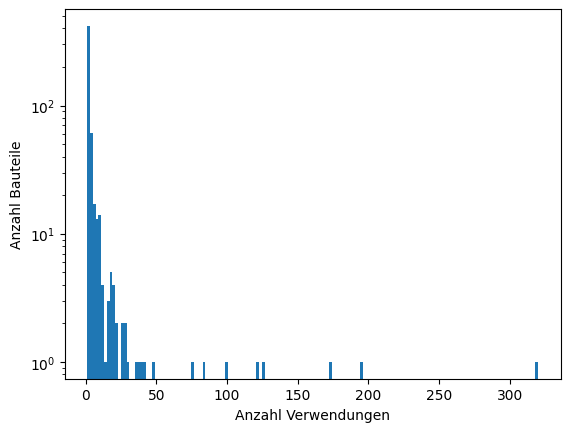

In [2]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(merged['Count'], bins=160, log=True)
ax.set_xlabel("Anzahl Verwendungen")
ax.set_ylabel("Anzahl Bauteile")

In [ ]:
merged.to_csv('../../res/results/cableprobes_counted_parts.csv')